In [1]:
# this notebook discuss about impact of learning rate of fine tuning

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from transformers import AutoModelForCausalLM, GPT2Tokenizer
import requests



/Users/raeez/.pyenv/versions/jupyter-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [8]:
seq_len = 256
batch_size = 16

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [19]:
# tokenize the text
# https://www.gutenberg.org/cache/epub/829/pg289.txt
text = requests.get('https://www.gutenberg.org/files/829/829-0.txt').text
gtTokens = tokenizer.encode(text, return_tensors='pt')[0]

uniq, counts = np.unique(gtTokens, return_counts=True)
freqidx = np.argsort(counts)[::-1]
top100 = uniq[freqidx[:100]]


In [21]:
def countFreqTokens(model):
    # radnom staritng tokens
    numreps = 10 # num of random repetitions
    numtoks = 100 # oputput length
    randstarts = torch.randint(tokenizer.vocab_size, (numreps,1)).to(device) # this creates a 10x1 matrix [10 btaches of one single starting token]

    out = model.generate(
        randstarts,
        max_length  = numtoks+1, #the first token is the row start in randstarts, so you need 100+1 total toks in output of generate()
        min_length = numtoks+1, # guarantee that model should generarte exact;y 100 toks
        do_sample = True,
        bad_words_ids = [tokenizer.encode(tokenizer.eos_token)],
        pad_token_id = tokenizer.encode(tokenizer.eos_token)[0]).cpu()

    #return proprotion
    # outout is the proportion of generated tokens that are also in the Gullivers Trabvels text
    return np.mean(100*np.isin(out[:,1:],top100).flatten())

In [22]:
def trainTheModel(lr, num_samples):
    # download a fresh copy of model
    gpt2 = AutoModelForCausalLM.from_pretrained('gpt2').to(device)

    # pre train evaluation
    pretrainEval = countFreqTokens(gpt2)

    # create optim func
    optimizer = torch.optim.AdamW(gpt2.parameters(), lr=lr, weight_decay=.01)
    #init the loss
    train_loss = np.zeros(num_samples)
    for sampli in range(num_samples):
        ix = torch.randint(len(gtTokens)-seq_len,size=(batch_size,))
        X = gtTokens[ix[:,None]+ torch.arange(seq_len)]
        X = X.to(device)
        
        gpt2.zero_grad()
        outputs= gpt2(X,labels=X)
        loss = outputs.loss
        
        loss.backward()
        optimizer.step()
        train_loss[sampli] = loss.item()

    psttrainEval = countFreqTokens(gpt2)
    return train_loss, pretrainEval, psttrainEval

Fine tune model with diff leearning rates

In [25]:
learningrates = [1e-4, 1e-5, 1e-6]
training_samples = 800

evalsPcts = np.zeros((3,2))
losses = []

for idx, lr in enumerate(learningrates):

    # train a fresh nodel and get resutls
    train_loss, pretrainEval, psttrainEval = trainTheModel(lr, training_samples)

    evalsPcts[idx,0]= pretrainEval
    evalsPcts[idx,1] =psttrainEval
    losses.append(train_loss)

Loading weights: 100%|█| 148/148 [00:00<00:00, 1880.30it/s, Materializing param=
GPT2LMHeadModel LOAD REPORT from: gpt2
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.
Loading weights: 100%|█| 148/148 [00:00<00:00, 1436.61it/s, Materializing param=
GPT2LMHeadModel LOAD REPORT from: gpt2
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different

In [23]:
#visualize the evaluations

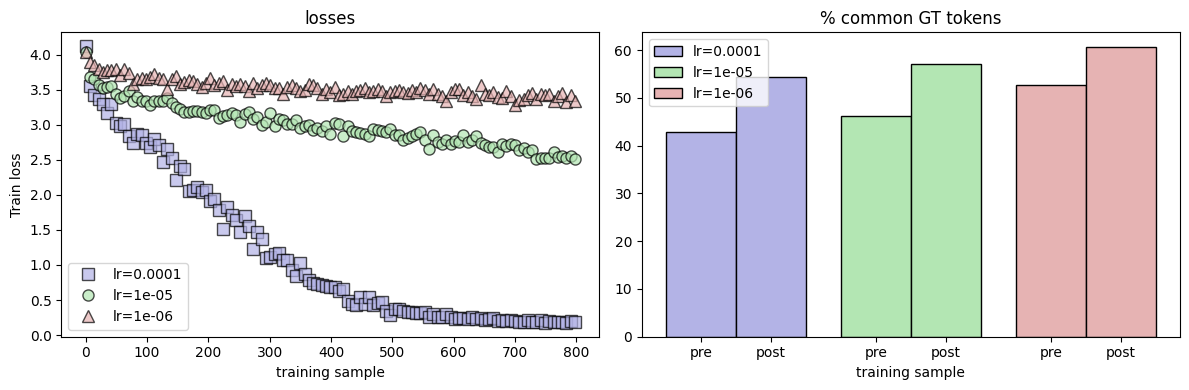

In [27]:
 _,axs = plt.subplots(1,2,figsize=(12,4))

colors = [[.7,.7,.9],[.7,.9,.7],[.9,.7,.7]]
shapes = 'so^'

# plot the losses
for i in range(3):
    #plot losses
    axs[0].plot(range(0,training_samples,7), losses[i][::7],f'k{shapes[i]}',markerfacecolor=colors[i],alpha=.7,
                markersize=8,label=f'lr={learningrates[i]}')

    #plot percent of common GT tokens
    axs[1].bar([i-.2,i+.2],evalsPcts[i,:],width=.4,edgecolor='k',facecolor=colors[i],label=f'lr={learningrates[i]}')

axs[0].set(xlabel='training sample',ylabel='Train loss', title='losses')
axs[0].legend()


axs[1].set(xlabel='training sample',xticks=[-.2,.2,.8,1.2,1.8,2.2],
           xticklabels=['pre','post','pre','post','pre','post'],
           title='% common GT tokens')
axs[1].legend()

plt.tight_layout()
plt.show()

we wouldn't want the fine tuning to completely erase the world knowledge that base model acquired during its pretrainig
we want something between which learns about our data and also retain the existing knowledg

to determin which lr is best, we need some additional evaluations
    more qualtitative evaluations